## Installation

In [0]:
pip install tensorflow==2.1.0 tensorflow_datasets==2.1.0

# K Means Clustering with RBFN for Imagery Clasification

In this project, we will use K-means clustering, a naive approach for grouping information, in combination with a radial basis function based neural network, in an attempt to classify images. In our particular case, we will be using the MNIST dataset, but the approach whould work when there is some level of generality between the shape/positioning of the objects within the image.

One very nice aspect of using this approach, is that clustering is a well understood method of averaging out the compontents of a dataset. Since our data set is visual in nature, we can view the parameters of the network visually after training to gain insight as to what's happening under the hood.


In [15]:
## Installation Check. Note TensorFlow should be at least version 2.0

import sys
import sklearn
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Alows for running in colab
%matplotlib inline

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))
print('TensorFlow: {}'.format(tf.__version__))
print('TensorFlow_Dataset: {}'.format(tfds.__version__))

Python: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Sklearn: 0.22.1
Matplotlib: 3.1.3
NumPy: 1.17.5
TensorFlow: 2.1.0
TensorFlow_Dataset: 2.1.0


### 1. Import the MNIST dataset

For this project, we will be using the MNIST dataset.  Note the assingment requested we use the skilearn dataset for importing MNIST, but through testing keras was found to be faster so we will substitute it in instead.

In [16]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [17]:
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


# Visualizing the dataset

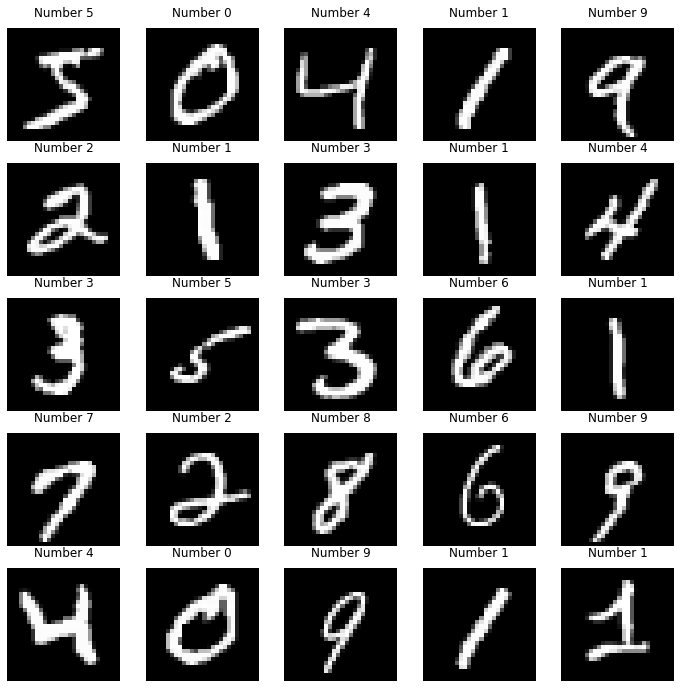

In [18]:
# Shows a subsample of the data for visualization purposes
plot_grid = [5,5] # grid sizing for the printed output

fig, axs = plt.subplots(plot_grid[0],plot_grid[1], figsize = (12, 12))
plt.gray()
# loop through subplots and display mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

### 2. Preprocessing the MNIST images

The K-means clustering algorythm requires the 2d nature of our images to be collapsed to a vector formated. Our 28x28 image will become a 784 dimensional vecctor. Tensorflow is less picky and able to handle 2d images more readily, but since our clusters will be in vector form, we will just treat the data as a vector and reshape into a 2d shape only when we want to view the data visually.

In [19]:
# preprocessing the images

# convert each image to 1 dimensional array
X = x_train.reshape(len(x_train),-1)
Y = y_train

X_test = x_test.reshape(len(x_test),-1)
Y_test = y_test

# normalize the data to 0 - 1
X = X.astype(float) / 255.
X_test = X_test.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


### 3. K-Means Clustering

As a first test, we will try clustering the data into 10 clusters, since there are 10 digits we wish to clasify. 

In [20]:
from sklearn.cluster import MiniBatchKMeans
n_digits = len(np.unique(y_test))
print("Testing with",  n_digits, "clusters")

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_digits,batch_size=500)

# Fit the model to the training data
kmeans.fit(X)

from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

def calcSignma(centers):
	num_centroids = centers.shape[0]
	dist = np.ndarray(shape=(num_centroids, num_centroids))
	#max distance between centroids
	for i in range (0,num_centroids):
		for j in range (0, num_centroids):
			dist[i][j] = distance.euclidean(centers[i], centers[j])
	# print dist.shape, dist, np.amax(dist)
	return np.amax(dist)/np.sqrt(num_centroids)
 
def calcSignma_mean(centers):
	num_centroids = centers.shape[0]
	dist = np.ndarray(shape=(num_centroids, num_centroids))
	#max distance between centroids
	for i in range (0,num_centroids):
		for j in range (0, num_centroids):
			dist[i][j] = distance.euclidean(centers[i], centers[j])
	# print dist.shape, dist, np.amax(dist)
	return np.mean(dist)#/np.sqrt(num_centroids)


print(calcSignma(kmeans.cluster_centers_))
print(calcSignma_mean(kmeans.cluster_centers_))

Testing with 10 clusters
2.501541816197424
4.879312974790585


### 4. Assigning Cluster Labels

Because of the way we created the clusters (completely randomly) there is nothing really tying the clusters generated to the labels/digits they have mapped from (in fact, they may not map to a single digit at all, we are only hoping they do based on visual similarity). Using the code below, sampled from the article: 
https://medium.com/@sangramsing/k-means-clustering-for-imagery-analysis-881ced89053d
we can make an educated guess as to which label would likely apply to a given centroid, and then work backwards to make predictions on a supplied digit as to which centroid it's most similar to and guess the label. 

In [0]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [22]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)

# Here we measure how often the predicted label lines up with the expected result
accuracy = sklearn.metrics.accuracy_score(Y,predicted_labels)


print("Accuracy: ", accuracy)
print("Comparison of predicted label using kmeans.predict for the first 30 items vs the actual labels:")

print(predicted_labels[:30])
print(Y[:30])




Accuracy:  0.5508166666666666
Comparison of predicted label using kmeans.predict for the first 30 items vs the actual labels:
[8 0 4 1 7 2 1 8 1 7 2 1 3 6 1 7 2 8 1 7 4 0 7 1 1 2 4 3 7 1]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]


### 5. Optimizing and Evaluating the Clustering Algorithm

Sicne we can associate a supplied image with the best batching cluster (using sklearn.cluster.MiniBatchKMeans.predict), using the above code to asscociate a cluster with a label and make dictions as to what label applies to an image. From there, we can evaluate the accuracy of our given clusters in terms of prediction power before we even attempt to use RBF training to further refine the data. 

In [0]:
from sklearn import metrics

# Since we're running metrics here, we'll convert the testing data as needed
# Reshape to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)
# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.


def calculate_cluster_metrics(estimator, data, labels):
    """
    Prints out the metrics of the suplied MiniBatchKMeans cluster
    """
    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

    cluster_labels = infer_cluster_labels(estimator, labels)

    #### Commented out, but shows an implemenation that allows the accuracy of clusters to be shown
    # predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    ##  Calculate and print accuracy
    # print('Cluster accuracy determined from X_train: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))


    # get the Y values (aka labels) as predicted from Kmeans (after being fitted) 
    predicted_Y_test = infer_data_labels(estimator.predict(X_test), cluster_labels)

    # Now that we know the predictions, we compare to the original labels
    print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_Y_test)))

In [24]:
clusters = [10, 16, 36, 64, 144, 256, 512]

# In order to determine a good number of clusters, we will print out the results of various 
# cluster sizings to determine an optimal arrangement.
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters,batch_size=500)
    estimator.fit(X)
    
    # print cluster metrics
    calculate_cluster_metrics(estimator, X, Y)

Number of Clusters: 10
Homogeneity: 0.48583553044585565
Accuracy: 0.5797

Number of Clusters: 16
Homogeneity: 0.5573170663205272
Accuracy: 0.6535

Number of Clusters: 36
Homogeneity: 0.6955829274858806
Accuracy: 0.8006

Number of Clusters: 64
Homogeneity: 0.7421091458729424
Accuracy: 0.8077

Number of Clusters: 144
Homogeneity: 0.8119897554853426
Accuracy: 0.8774

Number of Clusters: 256
Homogeneity: 0.8375304818756312
Accuracy: 0.9063

Number of Clusters: 512
Homogeneity: 0.8743909030309117
Accuracy: 0.9243



One important takeaway from this is that JUST using kmeans, we can obtain pretty high label prediction accuracies before even applying RBF learning. 

*   Over 80% with 64 clusters
*   Over 90% with 256 clusters

This means our network should AT LEAST outperform these clusters predictive qualities before considering actually using them. As well, because creating clusters can be so fast, it may make sense to come up with a way to generate multiple varaiations on clustering and checking accuracies to try and find optimal solutions. As well, it's clear from this that the more clusters we have,the more accurate our results. This makes sense, as having more clusters is effectivelylike storing more of the original dataset for comparison. 


### 6. Visualizing Cluster Centroids

The centroid of each cluster should be the most repsresentative (hopefully) of the various numbers in the MNIST dataset. This is becuase by using k-means, we will be essentially in a multi-dimensional space, clustering various similar numbers together. The centroid in this sense, effective functions as a sort of average of the images whose vectors seem similar. By visualizing the centroids, we can get an idea of what each cluster centroid is repsentative of.


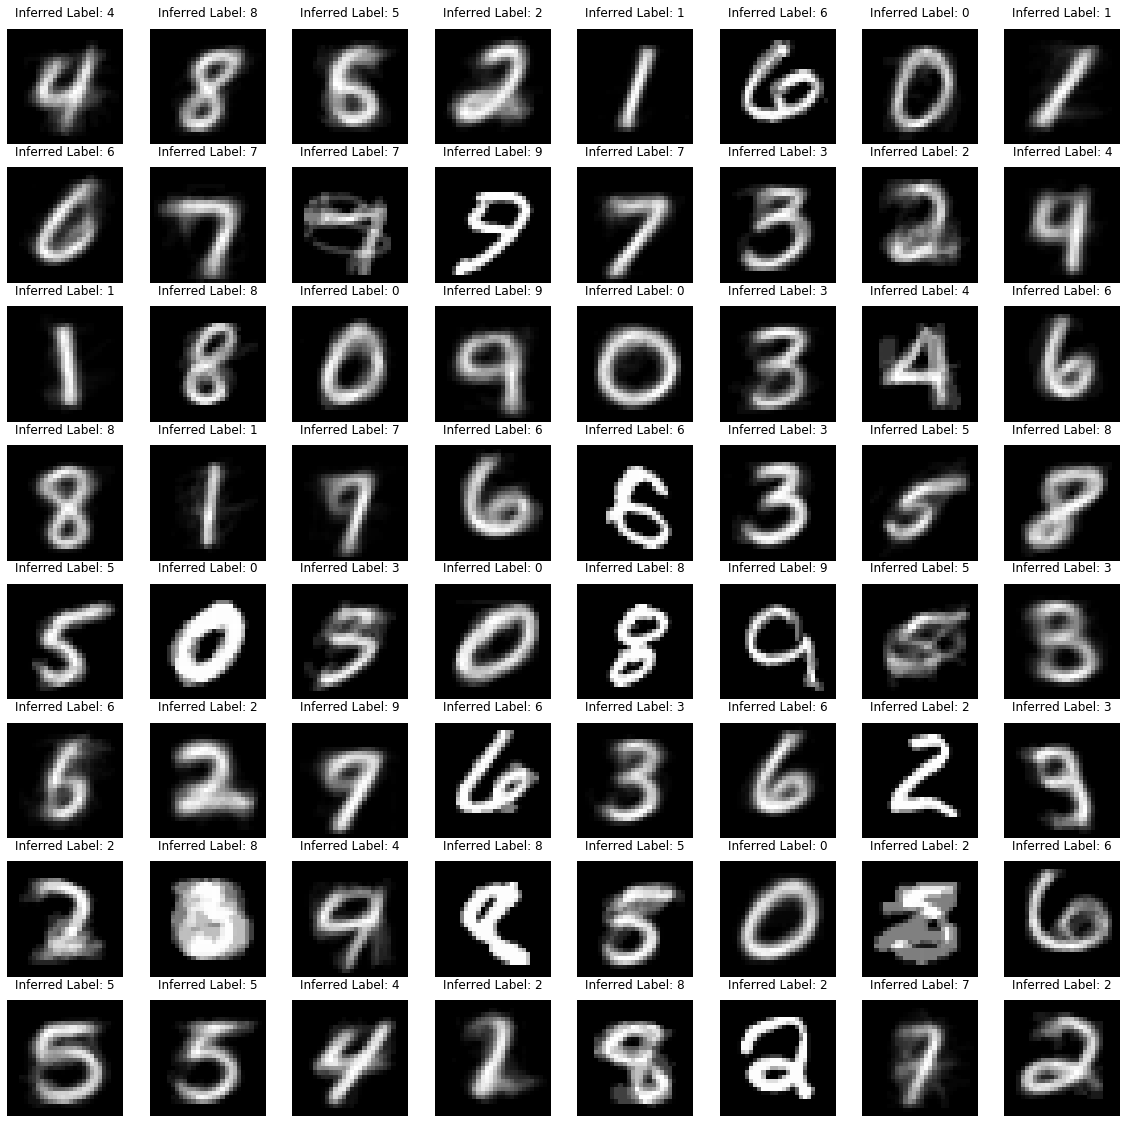

In [25]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 64)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(64, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(8, 8, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

When you run the above, you can clearly see "averaged" versions of the MNIST data, which generally looks like a number. Some clusters may be harder to distinguish, or have some noise between 2 similarly written numbers. The more clusters we supply, the more "specific" the variations look. For example, there may be 3 versions of a 1 which account for the various ways a one tends to be written (angled to the right, straight up/down). When you look at these visuals,one interesting thing to note is you can see numbers that tend to confuse each other as they look similar: example 1,4.

One takeaway from this, which we will not implement, but would be a REALLY good way to make the clusters work better, would be to take these "confused" numbers and create more clusters specifically for them. Essentially, if 4 is often mistaken for a 9, then dedicate more clusters to specifically identifying a 4 and 9. This can be done by taking counting all the digits which fail to be predicated, and then skewing the cluster generation algorythm towards those that often fail. 

# 7. Radial Basis Functions Setup

Here we are defining generalized functions which will let us use the information we gleaned from above directly into tensorflow. The code sourced from: https://github.com/PetraVidnerova/rbf_for_tf2 allows us to easily define RBF layers, directly integrating klearn.cluster.KMeans into the initialization of the layer (essentially, it performs kmeans with a number of clusters automatically based on the supplied layer size). Some of the code was modified slightly to better serve out needs here, but it's a great starting point for implementing an RBF in tensorflow and performs nicely.

In [0]:
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
from sklearn.cluster import KMeans, MiniBatchKMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100,batch_size=500):
        self.X = X
        self.max_iter = max_iter
        self.batch_size = batch_size
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]

        n_centers = shape[0]
        km = MiniBatchKMeans(n_clusters=n_centers, batch_size=self.batch_size, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)

        print(n_centers, " centroids formed")
        return km.cluster_centers_

## WIP: Modded version to ensure even division of clusters amongst labels. 
## Not complete, but the hope is if we perform some statistics on our dataset, 
## we can guess where to prioritize extra focus (example, commonly confused digits)
class InitCentersKMeansDividedMNIST(Initializer):
    import tensorflow_datasets as tfds

    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, max_iter=100,batch_size=500):
        self.max_iter = max_iter
        self.batch_size = batch_size
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]
        n_centers = shape[0]
        centers_per_label = n_centers / 10
        km = MiniBatchKMeans(n_clusters=centers_per_label, batch_size=self.batch_size, max_iter=self.max_iter, verbose=0)

        km.fit(self.X)

        print(n_centers, " centroids formed")
        return km.cluster_centers_

class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


# Model Creation:


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MSE

def _normalize_img(img, label):
  img = tf.cast(img, tf.float32) / 255.
  return (img, label)

## This will be used for genrating the centroids in model. The number of centroids will be determined by the 
initializer = InitCentersKMeans(X,max_iter=500) # Set the initalizer for generating the cluster centers

def create_model(n_clusters):
  model = tf.keras.models.Sequential()

  ## Here we initalize our RBF layer, with the supplied number of clusters/nodes, 
  ## the centers initializer (kmeans in ithis case) and supply the beta value, which is effectively
  ## the sigma value in the RBF.
  rbflayer = RBFLayer(n_clusters, initializer=initializer, betas=1, input_shape=(784,))
  model.add(rbflayer)
  outputlayer = Dense(10, activation='softmax')
  model.add(outputlayer)

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
  op_fn=tf.keras.optimizers.SGD(
          learning_rate=0.1, 
          momentum=0.05, 
          nesterov=True, 
          name='SGD'
      )
  
  op_fn = tf.keras.optimizers.Adam(learning_rate=0.005,)
  ## SGD was giving issues with stagnating

  model.compile(
      loss = loss_fn ,
      optimizer= op_fn, 
      metrics = ['sparse_categorical_crossentropy','accuracy'] )
  return model


# Training the network
Here we run through several iterations of the network training at various sizes to examine performance.  

In [28]:
# Parameters for training
EPOCH = 5

models = [create_model(30),create_model(40),create_model(50),create_model(80),create_model(100),create_model(140)]
model_size = [30,40,50,80,100,140]

## Single Run Through for testing
# models = [create_model(80)]
# model_size = [80]

30  centroids formed
40  centroids formed
50  centroids formed
80  centroids formed
100  centroids formed
140  centroids formed


In [29]:
### K-Fold Evaluation

from sklearn.model_selection import KFold
 
n_split=7

current_fold = 1
for train_index,test_index in KFold(n_split).split(X):
  print("#########  Training for K-fold", current_fold , "  #########")
  current_fold +=1

  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index]
  
  for i, model in enumerate(models):
    print("\nTraining model with",model_size[i],"centroids.")
    model.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=256, epochs= EPOCH, verbose=1)

#########  Training for K-fold 1   #########

Training model with 30 centroids.
Train on 51428 samples, validate on 8572 samples
Epoch 1/5
51428/51428 [==============================] - 5s 89us/sample - loss: 2.2781 - sparse_categorical_crossentropy: 2.2781 - accuracy: 0.1173 - val_loss: 2.1995 - val_sparse_categorical_crossentropy: 2.1995 - val_accuracy: 0.1366
Epoch 2/5
51428/51428 [==============================] - 2s 48us/sample - loss: 2.1322 - sparse_categorical_crossentropy: 2.1322 - accuracy: 0.1974 - val_loss: 2.0707 - val_sparse_categorical_crossentropy: 2.0707 - val_accuracy: 0.2531
Epoch 3/5
51428/51428 [==============================] - 2s 48us/sample - loss: 2.0484 - sparse_categorical_crossentropy: 2.0484 - accuracy: 0.2595 - val_loss: 2.0257 - val_sparse_categorical_crossentropy: 2.0257 - val_accuracy: 0.2765
Epoch 4/5
51428/51428 [==============================] - 3s 49us/sample - loss: 2.0087 - sparse_categorical_crossentropy: 2.0087 - accuracy: 0.2928 - val_loss: 1.9

In [30]:
### Fast-Testing, use train_number to K-fold train an above model more if desired. Essntially, if one cluster size looked more appropriate, this is a just a fact way to focus on it
n_split=8
current_fold = 1
train_num=3
EPOCH = 10

for train_index,test_index in KFold(n_split).split(X):
  print("#########  Training for K-fold", current_fold , "  #########")
  current_fold +=1

  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index]
  print("\nTraining model with",model_size[train_num],"centroids.")
  models[train_num].fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=256, epochs= EPOCH, verbose=1)

#########  Training for K-fold 1   #########

Training model with 80 centroids.
Train on 52500 samples, validate on 7500 samples
Epoch 1/10
52500/52500 [==============================] - 6s 110us/sample - loss: 0.4596 - sparse_categorical_crossentropy: 0.4596 - accuracy: 0.8755 - val_loss: 0.4626 - val_sparse_categorical_crossentropy: 0.4626 - val_accuracy: 0.8664
Epoch 2/10
52500/52500 [==============================] - 6s 110us/sample - loss: 0.4528 - sparse_categorical_crossentropy: 0.4528 - accuracy: 0.8762 - val_loss: 0.4636 - val_sparse_categorical_crossentropy: 0.4636 - val_accuracy: 0.8641
Epoch 3/10
52500/52500 [==============================] - 6s 109us/sample - loss: 0.4510 - sparse_categorical_crossentropy: 0.4510 - accuracy: 0.8766 - val_loss: 0.4596 - val_sparse_categorical_crossentropy: 0.4596 - val_accuracy: 0.8687
Epoch 4/10
52500/52500 [==============================] - 6s 109us/sample - loss: 0.4472 - sparse_categorical_crossentropy: 0.4472 - accuracy: 0.8785 - val_l

# Visualizing the Data
Now that we have a trained network, lets start analyzing the various features of the network visually digging into what's happening.

For starters, as was shown above, the centroids of this particular RBF network are effectively various numbers averaged out. Note this wasn't done explicitly, but by clustering the data. To view the clusters after training, we can use:

*   plot_centroids_as_img_grid()

which was created to show what the centroids look like after training in order to gain insight into what's happening. Note that most of the clusters still appear like averaged lettersand are barely changed. This makes sense as they are the most effective clusters at picking out "normal" digits. The other nodes created are essentially "distinguishers" which serve to filter the regions of an image important for distinguishing frequently confused letters.

In [0]:
class_names=[0,1,2,3,4,5,6,7,8,9]
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

def show_prediction_breakdown(model,rows=5,columns=5):
  num_images = rows*columns

  test_subset = X_test[:num_images]
  test_images = np.reshape(test_subset,(num_images,28,28))
  predictions = model.predict(X_test[:num_images])
  test_labels = y_test[:num_images]

  plt.figure(figsize=(2*2*columns, 2*rows))
  for i in range(num_images):
    plt.subplot(rows, 2*columns, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(rows, 2*columns, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
  plt.tight_layout()
  plt.show()


# def plot_centroids_as_img_grid(centroids,img_dimensions=[28,28],grid_size=[6,10]):
#   # reshape centroids into images (expected input)
#   image_count = centroids.shape[0]

#   images = np.reshape(centroids,(image_count,img_dimensions[0],img_dimensions[1]))
#   images *= 255 # Denormalize
#   images = images.astype(np.uint8)

#   # create figure with subplots using matplotlib.pyplot
#   fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize = (15, 15))
#   plt.gray()

#   # loop through subplots and add centroid images
#   for i, ax in enumerate(axs.flat):
#       # add image to subplot
#       ax.matshow(images[i])
#       ax.axis('off')

#   plt.tight_layout()
#   # display the figure
#   fig.show()

def plot_centroids_as_img_grid(centroids,img_dimensions=[28,28]):
  # reshape centroids into images (expected input)
  image_count = centroids.shape[0]

  images = np.reshape(centroids,(image_count,img_dimensions[0],img_dimensions[1]))
  images *= 255 # Denormalize
  images = images.astype(np.uint8)
  
  num_col = 10
  grid_width = int(image_count/num_col)
  grid_rows = int(image_count / grid_width)

  # create figure with subplots using matplotlib.pyplot
  fig, axs = plt.subplots(grid_width, grid_rows, figsize = (15, 15))
  plt.gray()

  # loop through subplots and add centroid images
  for i, ax in enumerate(axs.flat):
      # add image to subplot
      ax.matshow(images[i])
      ax.axis('off')

  
  plt.tight_layout()
  # display the figure
  fig.show()

# Centroids visualized
Perhaps the most interesting step, here we can view what our clusters look like after training to view how the network modified the images. Interestingly, only some nodes seemed to of been modifed through training. Some of the really "clean/recognizable" centroids appear to remain unchanged, whilst others have been modifed to pick up on the "differences" between supplied digtits. Essentially, the outside of the digts where a difference is most likely to be spotted seems to of been pulled out. 



Centroids of model size  80 visualized: 

Betas: [0.99953955 0.99953514 0.02571867 0.01886257 0.99856484 0.99943
 0.02009799 0.99593604 0.9965481  1.025862   1.0251052  0.02532103
 1.022967   0.03073773 0.01925821 0.999997   0.998933   0.99604034
 1.0183156  1.         0.97497654 0.97189236 0.9999863  0.9975698
 1.0003372  0.01804177 1.033725   1.0132074  0.01880769 1.1222771
 0.0168085  0.02073344 1.016253   1.0000226  0.02422927 1.
 0.9999965  1.2646075  0.02227685 1.         0.99997795 1.
 1.0028139  0.99675256 1.0051559  0.99958825 0.99942076 1.1697708
 1.         1.         0.99997854 1.         0.02118737 0.9343556
 1.         1.0027677  0.03936508 0.9999897  1.0074066  0.9999928
 0.99856454 1.0171555  0.9832828  1.0212057  0.02100241 0.02283588
 0.9990395  1.0016019  1.0003122  0.99999905 1.0023617  1.0005119
 1.0272343  1.0306507  1.0162327  0.02093092 1.         0.99999684
 1.0000005  0.9981075 ]


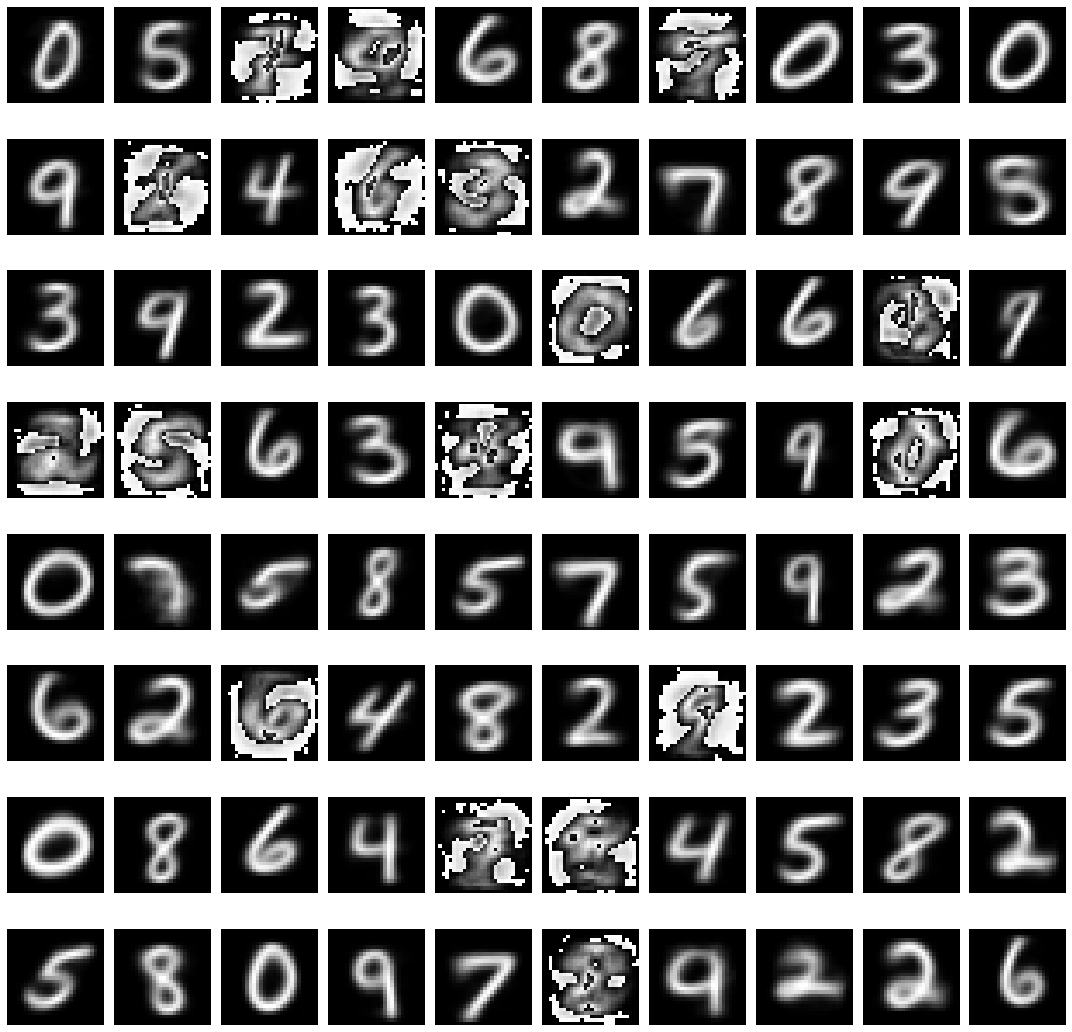

In [32]:
num=3
model = models[num]

centroids = model.get_layer(index=0).get_weights()[0]
betas = model.get_layer(index=0).get_weights()[1]

print('\nCentroids of model size ',model_size[num],'visualized: ')
plot_centroids_as_img_grid(centroids)
print('\nBetas: {}'.format(betas))

# Final Evaluation
We reserved some data, even though we did a k-folds analysis, for a final check through to make sure everything is functioning, and to summarize all the results. First we chow the accuracy of each cluster/nodes based on the amount of training, then we look at a portion of the data to see how it's performing at the indiciual character level. NOTE: This part has a bug, label is not being pulled correctly, so it shows an error (red) evenough though it's clear from the prediction graphs the correct label is being grabbed. 

Looking at the overall results, it looks like a 80 node sized RBFN performs quite nicely and strikes the balance between efficiency/prefiction.



Final Evaluated Accuracy Summary:
Model with:  30 clusters/hidden nodes with 10 epochs and 8 folds
10000/10000 [==============================] - 1s 104us/sample - loss: 0.7542 - sparse_categorical_crossentropy: 0.7542 - accuracy: 0.7909
Sample of performance


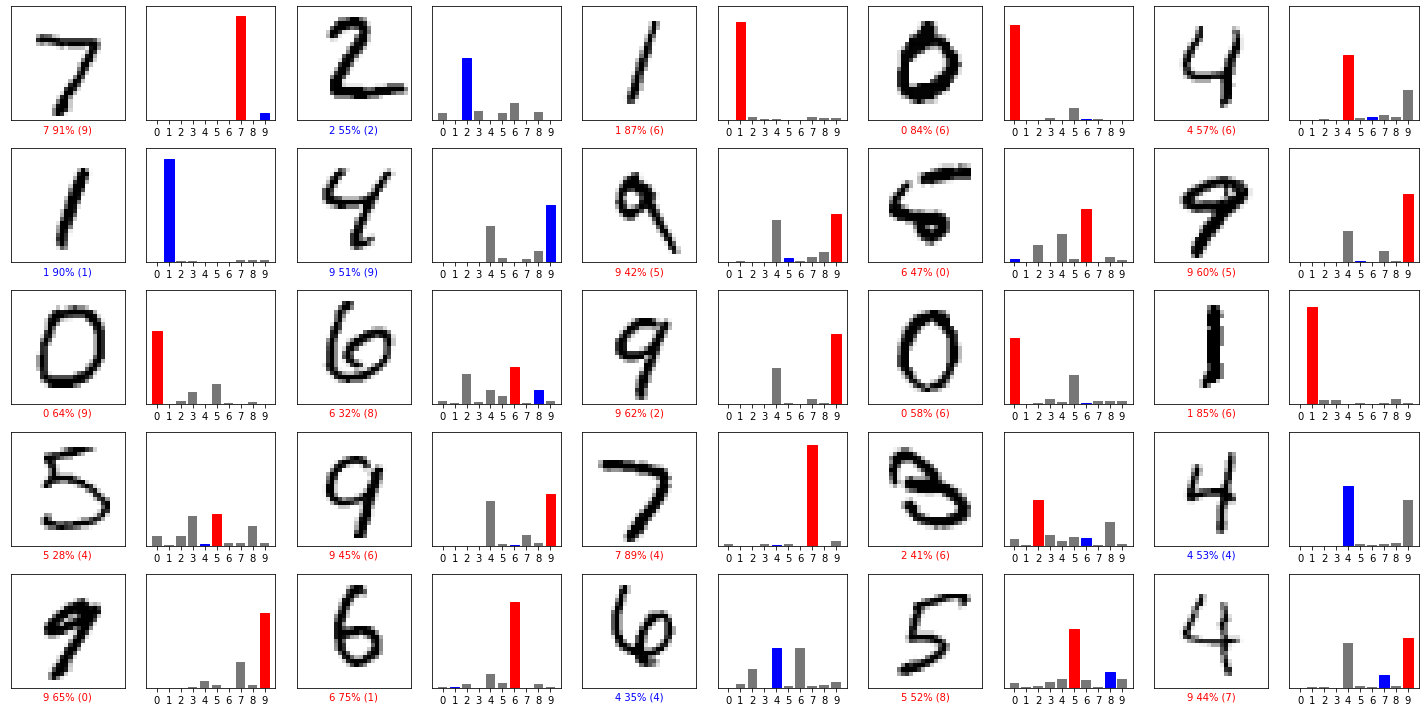

Model with:  40 clusters/hidden nodes with 10 epochs and 8 folds
10000/10000 [==============================] - 1s 116us/sample - loss: 0.5987 - sparse_categorical_crossentropy: 0.5987 - accuracy: 0.8431
Sample of performance


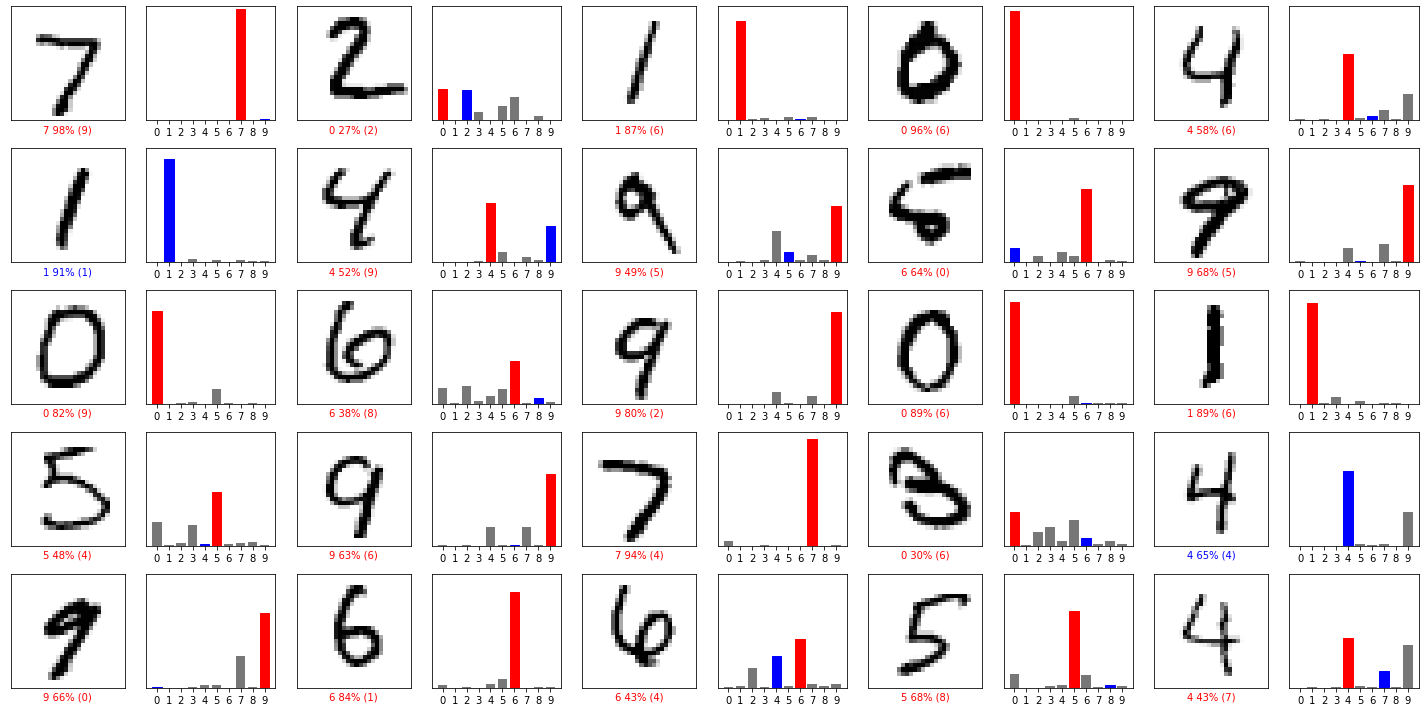

Model with:  50 clusters/hidden nodes with 10 epochs and 8 folds
10000/10000 [==============================] - 1s 122us/sample - loss: 0.5605 - sparse_categorical_crossentropy: 0.5605 - accuracy: 0.8573
Sample of performance


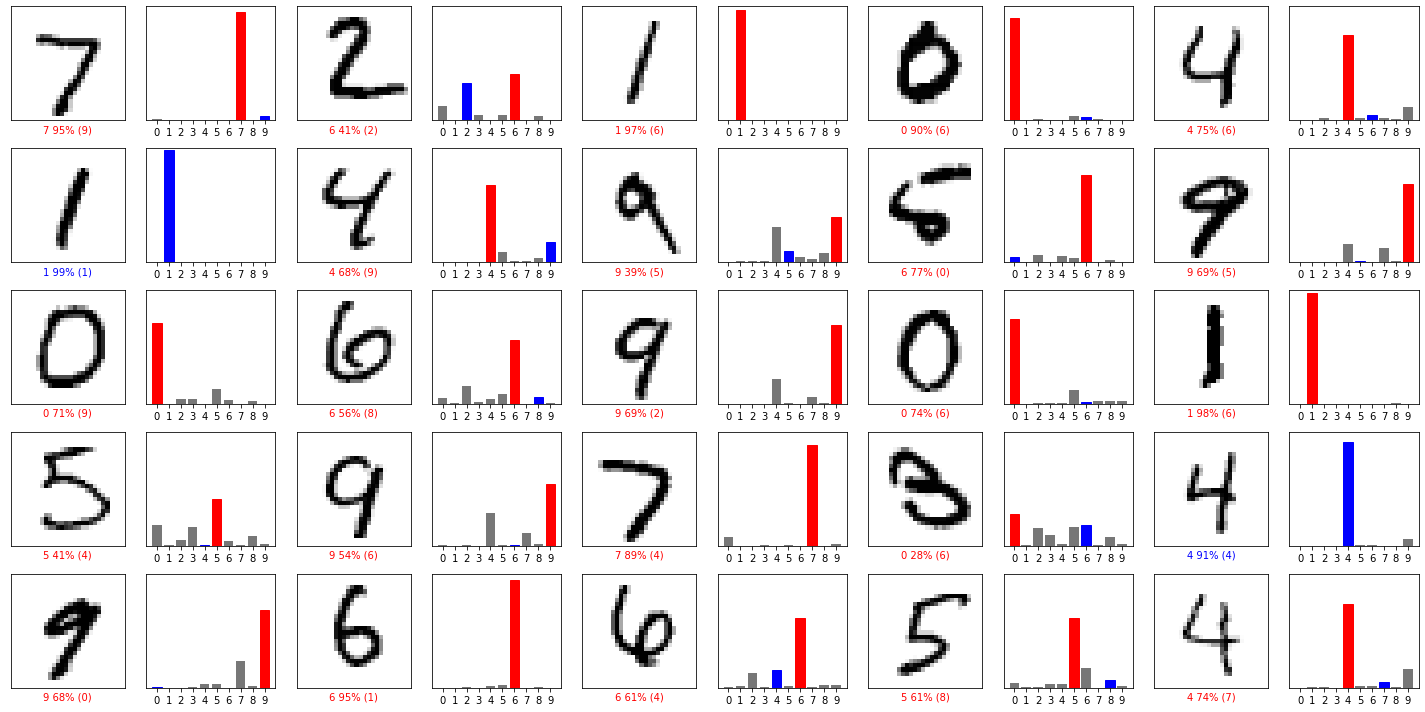

Model with:  80 clusters/hidden nodes with 10 epochs and 8 folds
10000/10000 [==============================] - 1s 149us/sample - loss: 0.3122 - sparse_categorical_crossentropy: 0.3122 - accuracy: 0.9082
Sample of performance


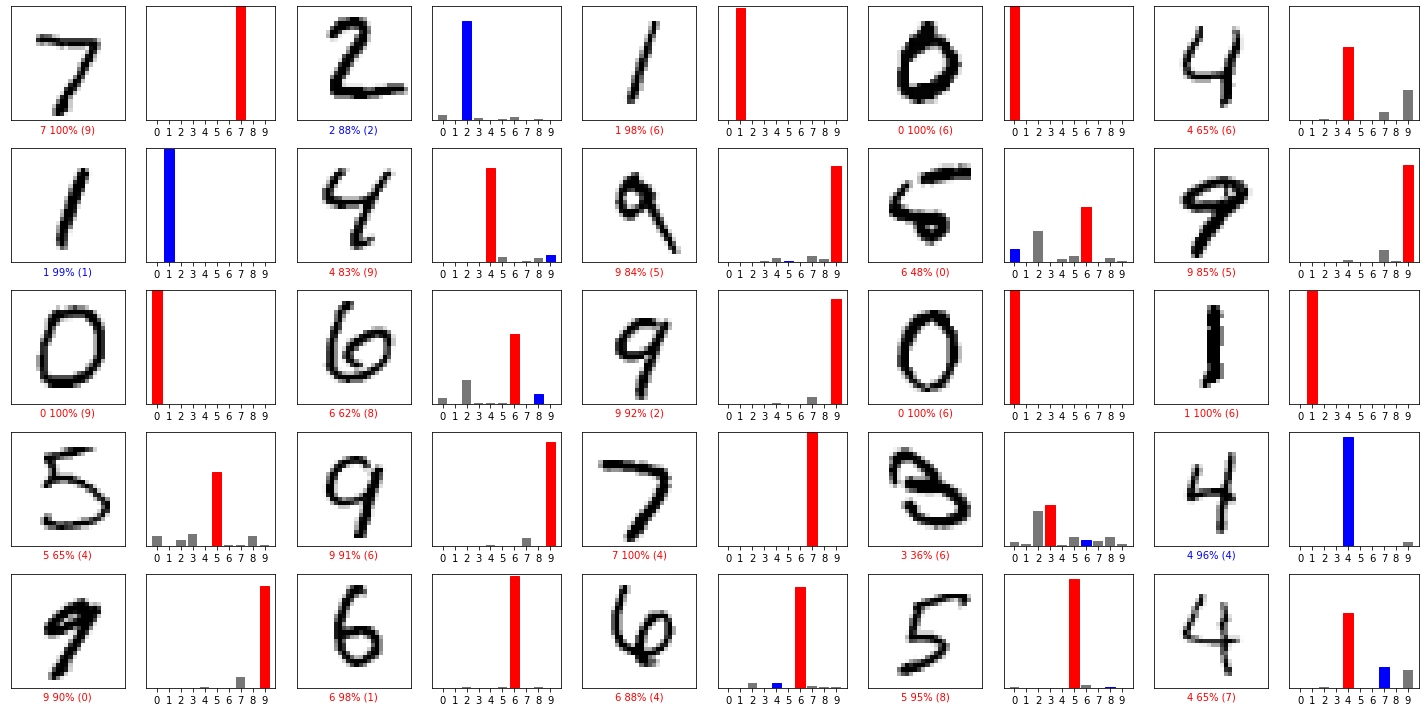

Model with:  100 clusters/hidden nodes with 10 epochs and 8 folds
10000/10000 [==============================] - 2s 156us/sample - loss: 0.4274 - sparse_categorical_crossentropy: 0.4274 - accuracy: 0.8700
Sample of performance


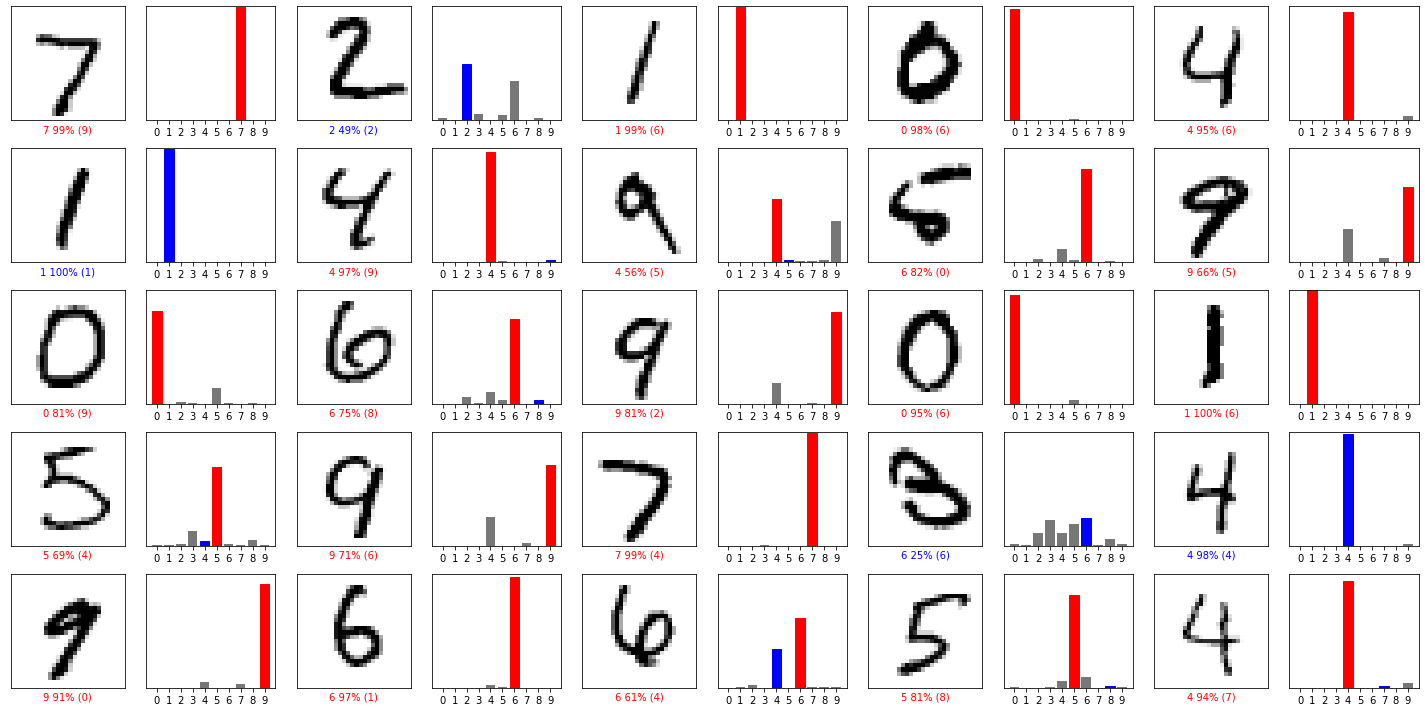

Model with:  140 clusters/hidden nodes with 10 epochs and 8 folds
10000/10000 [==============================] - 2s 183us/sample - loss: 0.4060 - sparse_categorical_crossentropy: 0.4060 - accuracy: 0.8832
Sample of performance


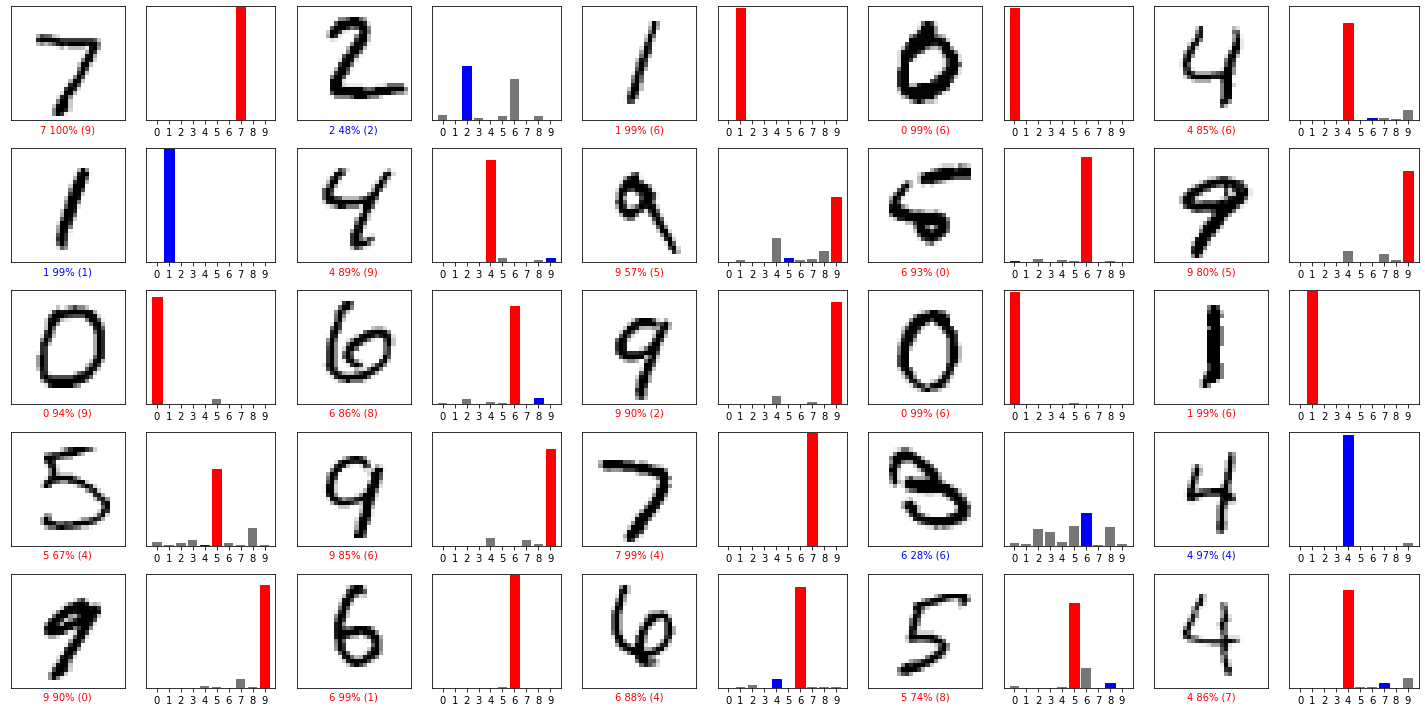

In [33]:
## Here we perform a final evaluation of all the generated networks, seeing how hight the accuracy is with the LEFT over data we've resevered for final testing.
## this data was not used for training, so it should reflect a true accuracy

print('Final Evaluated Accuracy Summary:')
for i, model in enumerate(models):
  print('Model with: ', model_size[i], 'clusters/hidden nodes with', EPOCH ,'epochs and', n_split, 'folds')
  model.evaluate(X_test,Y_test)
  print('Sample of performance') 
  show_prediction_breakdown(model) ### For some reason the label is showing incorrectly, even though it's clear from the graph the digit is correct